# Figure S5 | SpaGCN Domains vs T-types

In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.append("/code/")
from abc_merfish_analysis import abc_load as abc
from abc_merfish_analysis import ccf_erode as cerd
import abc_merfish_analysis.distance_metrics as dm

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['font.size'] = 7
get_ipython().run_line_magic('matplotlib', 'inline') 

In [2]:
# load all cells in the brain
obs = abc.get_combined_metadata(realigned=False)

In [3]:
# generate ccf_images & boundaries for the left hemisphere only
ccf_images_left = abc.get_ccf_labels_image(resampled=True, 
                                           realigned=False, 
                                           subset_to_left_hemi=True)

In [4]:
# We can load & use the published color palettes for the ABC Atlas taxonomy
abc_palettes = {level: abc.get_taxonomy_palette(level) for level in 
                ['neurotransmitter','class', 'subclass','supertype','cluster']}

# We have also provided a secondary color palette for the cluster level that 
# attempts to increase the color contrast between spatially negihboring clusters
abc_palettes['cluster'] = abc.get_thalamus_cluster_palette() 

In [5]:
# load in SpaGCN domain results
# temporarily a static file in '../code/resources' until I get a reproducible run setup for the spagcn capsule
spagcn_domains_df = pd.read_parquet('/data/spagcn/spagcn_predicted_domains.parquet')
# need to convert to categories since they're imported as int64
spagcn_domains_df = spagcn_domains_df.astype('category')

# merge in & subset to just cells with SpaGCN domain predictions
obs_spagcn = pd.merge(obs, spagcn_domains_df, on='cell_label', how='inner')

# filter by thalamus coords to tighten up the image
obs_spagcn = abc.filter_by_thalamus_coords(obs_spagcn)

# erode the CCF structures
ccf_level = 'structure' # compare at the parcellation_structure level
obs_spagcn_erode, ccf_label = cerd.label_cells_by_eroded_ccf(obs_spagcn.copy(), 
                                                             ccf_images_left, 
                                                             ccf_level=ccf_level)

In [6]:
results_dir = '../../results/'
figure_index = 'S5'

## Fig. S3A-C | Domains vs subclasses/supertypes/clusters

In [7]:
# set the SpaGCN resolution we want to visualize
resolution = 1.4
res_str = str(resolution)
predicted_col = f'res{res_str[0]}pt{res_str[-1]}'

In [8]:
# set color map
cmap = dm.CMAP_PURPLES_256
# dm.plot_cmap_lightness(cmap) # uncomment to see cmap is perceptually uniform

# set colorbar range
vmin = 0
vmax = 0.8

In [9]:
fig_letters = ['A', 'B', 'C']
fig_sizes = [
    [1.8,3],
    [5.8,3],
    [8.5,3],
]
taxonomy_levels = ['subclass', 'supertype', 'cluster']

domain_names_numerical_order = sorted(obs_spagcn[predicted_col].unique())

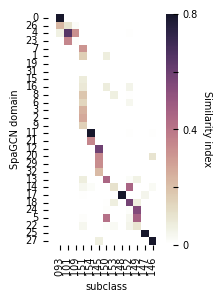

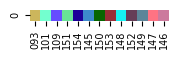

In [10]:
# Generate the subclass plot first
# 1. we'll re-order the SpaGCN domains on the y-axis according to their similarity to the subclasses
# 2. we'll use this order to fix  the y-axis order for the other taxonomy levels
subclass_ind = 0
taxonomy_level = taxonomy_levels[subclass_ind]


# Calculate similarity between SpaGCN domains & t-types
dist, y_names, x_names = dm.cluster_distances_from_labels(
                            obs_spagcn, 
                            y_col=predicted_col, 
                            x_col=taxonomy_level,
                            y_names=domain_names_numerical_order,
                            x_names=sorted(obs_spagcn[taxonomy_level].unique()),
                            metric='braycurtis')

y_order_from_subclass, x_order = dm.order_distances_x_to_y(
    dist, 
    reorder_y=True, # yes, reorder for the subclass
    min_similarity_x=0.1
)

x_names_ids_only = [name[0:4] for name in x_names]

# Plot similarity heatmap
fig = dm.plot_ordered_similarity_heatmap(
    dist, 
    y_order=y_order_from_subclass, 
    x_order=x_order, 
    y_names=y_names, 
    x_names=x_names_ids_only,
    cmap=cmap, 
    vmin=vmin, vmax=vmax,
)
ax = fig.gca()
ax.axis('equal')
ax.set_xlabel(f'{taxonomy_level}')
ax.set_ylabel('SpaGCN domain')
fig.set_size_inches(fig_sizes[subclass_ind])

fig.savefig(f'{results_dir}/fig{figure_index}{fig_letters[subclass_ind]}_similarity_heatmap_{taxonomy_level}_vs_spaGCN_domains_reorderedY.pdf', 
            transparent=True, 
            bbox_inches='tight')

# Plot colored labels for the x-axis categories
fig_xlabel_colors = dm.plot_heatmap_xlabel_colors(x_names, 
                                                    x_order, 
                                                    abc_palettes[taxonomy_level])
fig_xlabel_colors.set_size_inches(fig_sizes[subclass_ind])
fig_xlabel_colors.savefig(f'{results_dir}/fig{figure_index}{fig_letters[subclass_ind]}_similarity_heatmap_{taxonomy_level}_vs_spaGCN_domains_xaxis_colors.pdf', 
                            transparent=True, 
                            bbox_inches='tight')

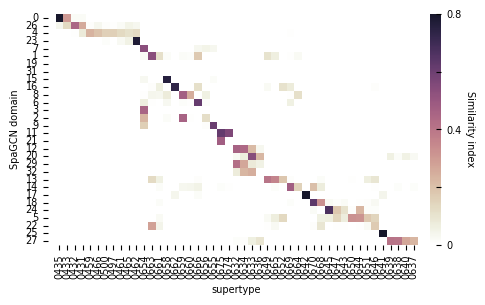

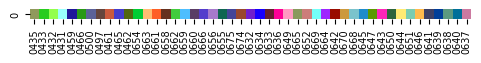

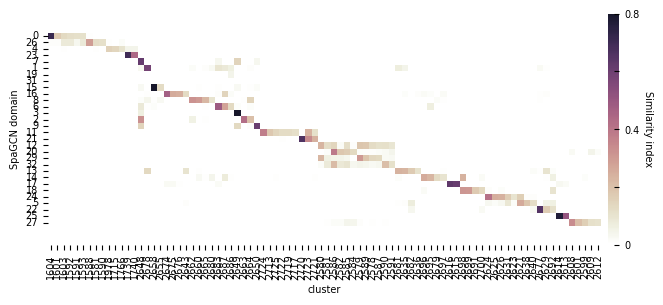

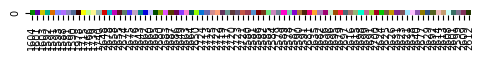

In [11]:
# Plot the other two taxonomy levels, supertype & cluster

# use the y_order from the subclass plot to fix the SpaGCN domain order
y_names_subclass_order = np.array(domain_names_numerical_order)[y_order_from_subclass]

for i, taxonomy_level in enumerate(taxonomy_levels):
    # skip the subclass level since we already plotted it
    if i == subclass_ind:
        continue
    
    # Calculate similarity between SpaGCN domains & t-types
    dist, y_names, x_names = dm.cluster_distances_from_labels(
                                obs_spagcn, 
                                y_col=predicted_col, 
                                x_col=taxonomy_level,
                                y_names=y_names_subclass_order,
                                x_names=sorted(obs_spagcn[taxonomy_level].unique()),
                                metric='braycurtis')

    y_order, x_order = dm.order_distances_x_to_y(dist, 
                                                reorder_y=False, 
                                                min_similarity_x=0.1)

    x_names_ids_only = [name[0:4] for name in x_names]

    # Plot similarity heatmap
    fig = dm.plot_ordered_similarity_heatmap(
        dist, 
        y_order=y_order, x_order=x_order, 
        y_names=y_names, x_names=x_names_ids_only,
        cmap=cmap, 
        vmin=vmin, vmax=vmax,
    )
    ax = fig.gca()
    ax.axis('equal')
    ax.set_xlabel(f'{taxonomy_level}')
    ax.set_ylabel('SpaGCN domain')
    fig.set_size_inches(fig_sizes[i])

    fig.savefig(f'{results_dir}/fig{figure_index}{fig_letters[i]}_similarity_heatmap_{taxonomy_level}_vs_spaGCN_domains_yOrderSubclass.pdf', 
                transparent=True, 
                bbox_inches='tight')
    
    # Plot colored labels for the x-axis categories
    fig_xlabel_colors = dm.plot_heatmap_xlabel_colors(x_names, 
                                                     x_order, 
                                                     abc_palettes[taxonomy_level])
    fig_xlabel_colors.set_size_inches(5.7,3)
    fig_xlabel_colors.savefig(f'{results_dir}/fig{figure_index}{fig_letters[i]}_similarity_heatmap_{taxonomy_level}_vs_spaGCN_domains_xaxis_colors.pdf', 
                              transparent=True, 
                              bbox_inches='tight')